## Number classifier task

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [30]:
#Helper extraction functions

def extract_data(path):
    """Load data file"""
    return np.loadtxt(path, dtype=np.int16, delimiter=',')

def reshape_matrix(mat):
    """Reshape each line in the matrix into a quadratic image"""
    reshapedMat = []
    
    for i in range(np.size(mat,0)):
        reshapedMat.append(mat[i,:].reshape(28,28))

    return np.array(reshapedMat)

In [31]:
# Extract data from csv files

trainv = extract_data("numbers_data/trainv.csv")  
testv = extract_data("numbers_data/testv.csv")
trainlab = extract_data("numbers_data/trainlab.csv")
testlab = extract_data("numbers_data/testlab.csv")

In [32]:
# Toy example to figure out numpy functions

# List of 2x2 images already classified
train = np.array([
    [1, 1, 1, 1], 
    [2, 2, 2, 2],
    [3, 3, 3, 3],
    [4, 4, 4, 4]
])

label = np.array(["1", "2", "3", "4"])

# Images we want classified
test = np.array([
    [0, 0, 0, 0],
    [1, 1, 1, 1],
    [5, 5, 5, 5]
])

print(train.shape)
print(test.shape)

# For each element in test: subtract it from all elements in data
# We should get a new matrix for each element in test
diff = train - test[:, np.newaxis]
print("Difference")
print(diff)

# Calculate the norm. Each row in the matrix is the distance between one test and all train
norm1 = np.linalg.norm(diff, axis=2)
print("\nNorm 1")
print(norm1)


# Choose the smallest distance
nn_idx = np.argmin(norm1, axis=1)
print("\nClosest training sample index")
print(nn_idx)

# Print the label
predicted_class = label[nn_idx]
print("\nClosest training sample class")
print(predicted_class)

(4, 4)
(3, 4)
Difference
[[[ 1  1  1  1]
  [ 2  2  2  2]
  [ 3  3  3  3]
  [ 4  4  4  4]]

 [[ 0  0  0  0]
  [ 1  1  1  1]
  [ 2  2  2  2]
  [ 3  3  3  3]]

 [[-4 -4 -4 -4]
  [-3 -3 -3 -3]
  [-2 -2 -2 -2]
  [-1 -1 -1 -1]]]

Norm 1
[[2. 4. 6. 8.]
 [0. 2. 4. 6.]
 [8. 6. 4. 2.]]

Closest training sample index
[0 0 3]

Closest training sample class
['1' '1' '4']


In [33]:
# Calculate results of NN
import scipy.spatial

start = 0
n_samples = int(1e4)
buff_size = 500

nn_idx = np.zeros(n_samples, dtype=int)

for i in range(start, n_samples, buff_size):
    # diff = (trainv - testv[i:i+buff_size, np.newaxis])
    # norm = np.linalg.norm(diff, axis=2)
    norm = scipy.spatial.distance.cdist(testv[i:i+buff_size], trainv, metric="euclidean")  # this is 10x faster than the above lines
    nn_idx[i:i+buff_size] = np.argmin(norm, axis=1)

nn_pred = trainlab[nn_idx]
correct_predictions = (testlab[:n_samples] == nn_pred)
print(sum(correct_predictions)/n_samples)

0.9691


In [34]:
np.savetxt("pred_no_cluster.txt", nn_idx, fmt="%.d")

##### Confusion matrix and error rates

0: classifier has error rate 0.02014098690835851 (20 errors, 993 samples)
1: classifier has error rate 0.032562125107112254 (38 errors, 1167 samples)
2: classifier has error rate 0.015873015873015872 (16 errors, 1008 samples)
3: classifier has error rate 0.03865213082259663 (39 errors, 1009 samples)
4: classifier has error rate 0.027806385169927908 (27 errors, 971 samples)
5: classifier has error rate 0.048672566371681415 (44 errors, 904 samples)
6: classifier has error rate 0.018711018711018712 (18 errors, 962 samples)
7: classifier has error rate 0.04339440694310511 (45 errors, 1037 samples)
8: classifier has error rate 0.019189765458422176 (18 errors, 938 samples)
9: classifier has error rate 0.043521266073194856 (44 errors, 1011 samples)


Text(0.5, 1.0, 'NN-classifier with no clustering')

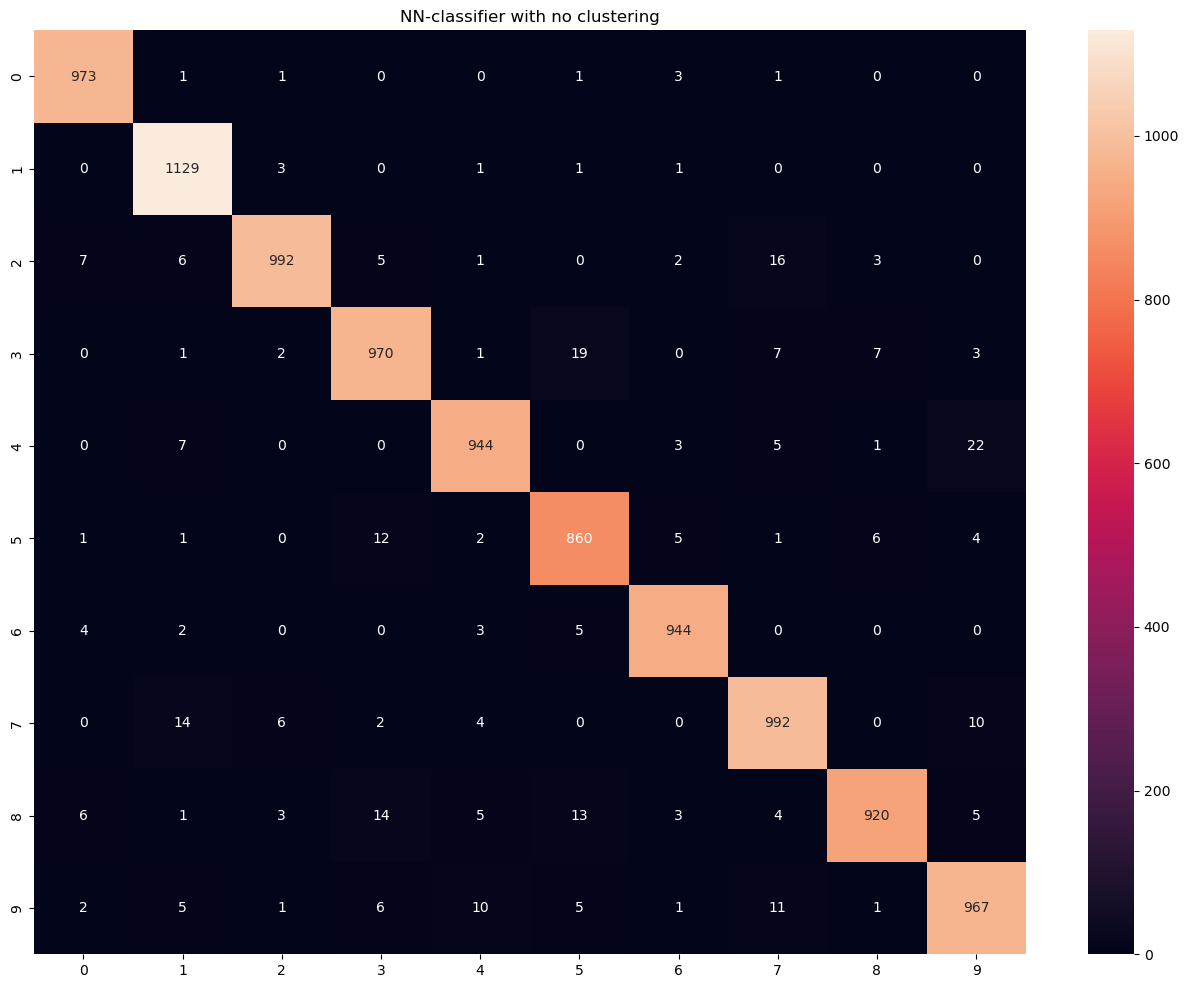

In [35]:
import seaborn as sn

# set starting value of all counters to 0
prediction_dict = {i: [0,0,0] for i in range(10)}
confMatrix = np.zeros((10,10))

correct_predictions_idx = []
false_predictions_idx = []

for i in range(np.size(testlab)):
    # create confusion matrix
    confMatrix[testlab[i]][nn_pred[i]] += 1
    # count how many times this number is in the dataset
    prediction_dict[nn_pred[i]][0] += 1
    
    if correct_predictions[i]:
    # count how many times this number has been correctly classified
        prediction_dict[nn_pred[i]][1] += 1
    # add correct prediction index to list
        correct_predictions_idx.append([i, nn_pred[i]])
    else:
    # count how many times it has been incorrectly classified
        prediction_dict[nn_pred[i]][2] += 1
    # add incorrect prediction to list
        false_predictions_idx.append([i, nn_pred[i]])

for i in range(10):
    print(f"{i}: classifier has error rate {prediction_dict[i][2]/prediction_dict[i][0]} ({prediction_dict[i][2]} errors, {prediction_dict[i][0]} samples)")

plt.figure(figsize = (16,12))
sn.heatmap(confMatrix, annot=True, fmt='.4g').set_title('NN-classifier with no clustering')
    

##### Some correctly classified and missclassified images

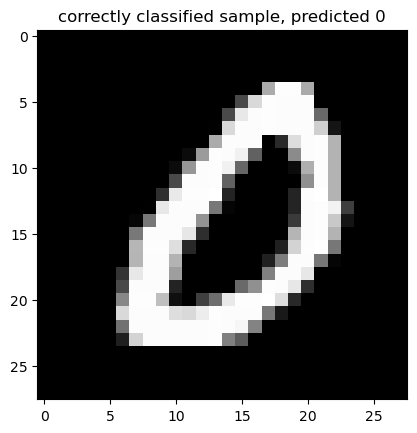

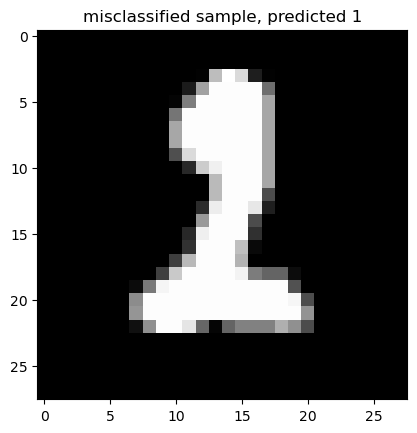

In [36]:
# Reshaped data contains images
reshapedTrainv = reshape_matrix(trainv)
reshapedTestv = reshape_matrix(testv)

num_samples = 1
np.random.seed(42)

for i in range(num_samples):
    random_correct_idx = np.random.randint(0,np.size(correct_predictions_idx, 0))
    random_false_idx = np.random.randint(0,np.size(false_predictions_idx, 0))
    
    plt.figure(i)
    plt.imshow(reshapedTestv[correct_predictions_idx[random_correct_idx][0]], cmap='gray')
    plt.title(f"correctly classified sample, predicted {correct_predictions_idx[random_correct_idx][1]}")
    
    plt.figure(i+num_samples)
    plt.imshow(reshapedTestv[false_predictions_idx[random_false_idx][0]], cmap='gray')
    plt.title(f"misclassified sample, predicted {false_predictions_idx[random_false_idx][1]}")


#### KNN-Classifier with K-means clustering

In [110]:
def recursive_K_means_algorithm(Data, k, N):
    # form k initial centroids
    Ci = np.random.uniform(0, 255, (k, 784))
    
    iterations = 0
    converged = False
    while iterations < N and not converged:
        # initialize k clusters 
        clusters = [[] for _ in range(k)]
        
        distance_to_centroid = np.array(scipy.spatial.distance.cdist(Data, Ci, metric='euclidean'))
        cluster_idx = np.argmin(distance_to_centroid, axis=1)
        

        for i in range(k):
            # Iterate over all clusters and assign the closest points to their respective cluster
            cluster_data = Data[cluster_idx == i]
            clusters[i] = cluster_data
        
        for i in range(k):
            # might want to keep old centroid, if there are no new points in a cluster
            if len(clusters[i]) > 0:
                Ci[i] = np.mean(clusters[i], axis=0)

        iterations += 1
    
    return Ci, clusters

In [111]:
Ci, clusters = recursive_K_means_algorithm(trainv, 64, 10)

#### Sklearn kmeans algorithm (NP-hard problem to solve)

In [ ]:
import sklearn.cluster as sk

M = 64

kmeans = sk.KMeans(n_clusters=M, random_state=42)
id_xi = kmeans.fit_predict(trainv)
Ci = kmeans.cluster_centers_